# Part 1

In [440]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from bs4 import BeautifulSoup
from IPython.display import display_html
import requests
import re
import seaborn as sns

In [345]:
req = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(req.content,'lxml')
table = soup.find_all('table')[0]

The main body of code below is using the beautiful soup library to parse out the different entries 
Each paragraph contains the information for each of the postal codes
All of the postal codes fall in a separate container than all of the boroughs and neighborhoods so that is extracted first

In [346]:
postalcode_list = [] # list of postal codes
borough_list = [] # list of boroughs
neighborhood_list = [] # list of neighborhoods
for x in table.find_all('p'): # finds all of the paragraphs in the HTML document
    neigh_sublist = [] # a sublist to be able to parse the boroughs from the neighborhoods
    list_a = x.find_all('a') # finding all instances of the a class which contains the boroughs and neighborhoods info
    if len(list_a) == 0: # if there is nothing assigned then just pass
        continue
    else:
        postalcode_list.append(x.b.text)
        # the for loops goes through each of the different a containers
        for a in list_a:
            neigh_sublist.append(a.text)
        borough_list.append(neigh_sublist[0])
        # determines how to handle the information, the first element is always borough and the rest are neighborhoods
        if len(neigh_sublist[1:]) == 0:
            neighborhood_list.append(neigh_sublist[0])
        elif len(neigh_sublist[1:]) == 1:
            neighborhood_list.append(neigh_sublist[1])
        else:
            neighborhood_list.append(', '.join(neigh_sublist))

In [347]:
df_full = pd.DataFrame(list(zip(postalcode_list,borough_list,neighborhood_list)),columns = ["PostalCode",'Borough','Neighborhood'])

In [348]:
df_full.head(20)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Downtown Toronto, Regent Park, Harbourfront"
3,M6A,North York,"North York, Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Scarborough, Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"East York, Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Downtown Toronto, Garden District, Ryerson"


In [351]:
df_full.shape

(101, 3)

# Part 2

In [353]:
#!conda install -c conda-forge geocoder=1.38.1 --yes
import geocoder

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\bmehl\Anaconda3

  added / updated specs:
    - geocoder=1.38.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.3                |   py37hc8dfbb8_1         3.1 MB  conda-forge
    geocoder-1.38.1            |             py_1          53 KB  conda-forge
    python_abi-3.7             |          1_cp37m           4 KB  conda-forge
    ratelim-0.1.6              |             py_2           6 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be INSTALLED:

  geocoder           conda-forge/noarch::geocoder-1.38.1-py_1
  python_abi         conda-forge/win-64::python_abi-3.7-1_cp37m
  ratelim            conda-forge/noarch::ratelim-0.1.6-py_2

The following packa



==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda




This first code block was my attempt at using geocoder. 

It failed to find a value after 30 mins so i uploaded the csv dataset instead

In [421]:
#import geocoder # import geocoder

# initialize your variable to None
#lat_lng_coords = None

# loop until you get the coordinates
#while(lat_lng_coords is None):
#    g = geocoder.google('{}, Toronto, Ontario'.format('M4A'))
#    lat_lng_coords = g.latlng

#latitude = lat_lng_coords[0]
#longitude = lat_lng_coords[1]

In [371]:
lat_lng = pd.read_csv('Geospatial_Coordinates.csv',index_col = 0)

In [404]:
values_list = []
for x in df_full['PostalCode']:
    values_list.append(lat_lng.loc[x])
lat_lng_df =pd.DataFrame(values_list,columns = ['Latitude','Longitude'])
lat_lng_df.reset_index(inplace=True)

In [420]:
df_complete = df_full.join(lat_lng_df[['Latitude','Longitude']])

In [437]:
df_complete.tail()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
96,M8X,Etobicoke,"Etobicoke, The Kingsway, Old Mill",43.653654,-79.506944
97,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
98,M7Y,Business reply mail,Business reply mail,43.662744,-79.321558
99,M8Y,Etobicoke,"Etobicoke, Old Mill, Sunnylea, Humber Bay, Mim...",43.636258,-79.498509
100,M8Z,Etobicoke,"Etobicoke, Mimico, The Queensway",43.628841,-79.520999


# Part 3

This is where i define a subset of data to be used while fitting the system.

The subset is the boroughs that explicitly mention Toronto in their name.

In [439]:
df_subset = df_complete[df_complete['Borough'].str.match('[A-Z][a-z]* Toronto')]

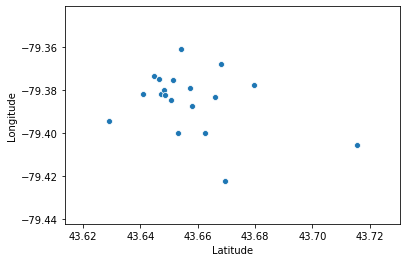

In [442]:
sns.scatterplot(x = 'Latitude', y= 'Longitude',data = df_subset)

In [ ]:
X= df_subset[['Latitude','Longitude']]

I use this frame to determine the number of clusters to use for this analysis.

For determining which to use, its sort of arbitrary since using more clusters will always produce a better fit but
a more informative fit. I used the criteria where there was a "small difference between going up to a higher
number of clusters versus staying at the same number. In this case i chose 4 clusters

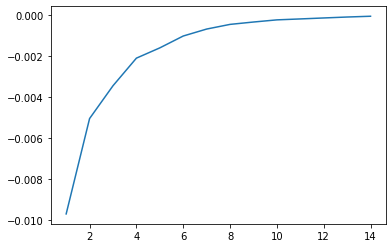

In [487]:
scores = []
for x in range(1,15):
    kmeans = KMeans(n_clusters = x,init = "k-means++")
    kmeans.fit(X)
    
    scores.append(kmeans.score(X))
plt.plot(range(1,15),scores)

In [488]:
kmeans = KMeans(n_clusters = 4,init = "k-means++")
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

the plot below shows highlights the different clusters that were formed.

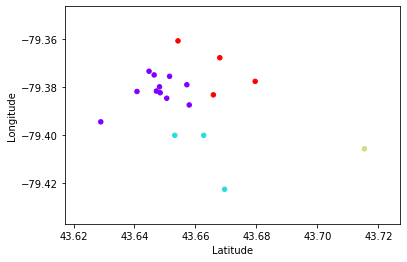

In [505]:
df_subset.plot.scatter('Latitude','Longitude',c=kmeans.labels_,cmap='rainbow',sharex=False,secondary_y=False,colorbar= False)

The next thing i decided to do was look at the picture as a whole and see if the clusters are in similar locations in the overall data set

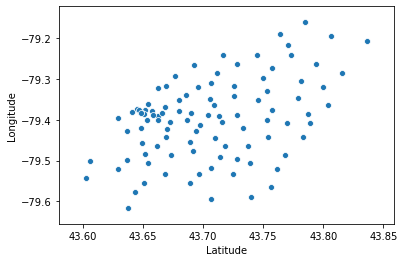

In [491]:
sns.scatterplot(x = 'Latitude', y= 'Longitude',data = df_complete)

In [493]:
X_full= df_complete[['Latitude','Longitude']]
kmeans_full = KMeans(n_clusters = 4,init = "k-means++")
kmeans_full.fit(X_full)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

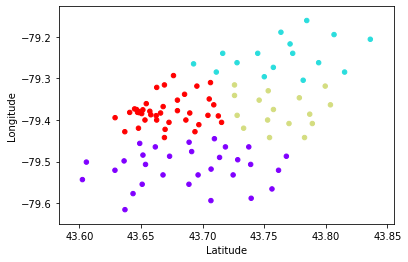

In [504]:
df_complete.plot.scatter('Latitude','Longitude',c=kmeans_full.labels_,cmap='rainbow', sharex=False,secondary_y=False,colorbar= False)

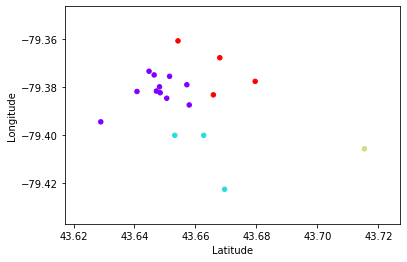

In [506]:
df_subset.plot.scatter('Latitude','Longitude',c=kmeans.labels_,cmap='rainbow',sharex=False,secondary_y=False,colorbar= False)

we notice that there are some discrepancies between the two plots between the identification of the points but overall the locations are fairly similar, there is a "North", "South", "West", and "East" side to the city